In [ ]:
pip install xgboost lightgbm

In [21]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import GridSearchCV, train_test_split
from xgboost import XGBClassifier
from sklearn.metrics import roc_curve
from sklearn.impute import KNNImputer

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Necesito-un-credito/train.csv'
file_key_2 = 'Necesito-un-credito/test.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

## Reading data-files
train = pd.read_csv(file_content_stream_1)
train['age'] = [train['age'][i][:-1] for i in range(0, train.shape[0])]
train['age'] = pd.to_numeric(train['age'])

test = pd.read_csv(file_content_stream_2)
test['age'] = [test['age'][i][:-1] for i in range(0, test.shape[0])]
test['age'] = pd.to_numeric(test['age'])

# Basic Exploration

In [2]:
train.head()

,Id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
0,30894,0,0.155646,59,0,0.596508,7330.0,12,0,3,0,0.0
1,59640,0,0.925853,42,0,0.513760,6249.0,6,0,2,0,4.0
2,83465,0,0.066454,62,1,0.346516,8166.0,17,0,2,0,1.0
3,144373,0,0.044920,49,1,838.000000,NaN,9,0,1,0,3.0
4,98153,0,0.429878,51,2,10046.000000,NaN,11,0,3,0,1.0


In [3]:
train['SeriousDlqin2yrs'].value_counts() / train.shape[0]

0    0.932773
1    0.067227
Name: SeriousDlqin2yrs, dtype: float64

In [4]:
train.describe()

,Id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents
count,73363.000000,73363.000000,73363.000000,73363.000000,73363.000000,73363.000000,5.884400e+04,73363.000000,73363.000000,73363.000000,73363.000000,71431.000000
mean,75067.068550,0.067227,4.992171,52.321743,0.423074,350.029652,6.660668e+03,8.465316,0.266933,1.020623,0.241811,0.757066
std,43338.771548,0.250417,188.133666,14.737304,4.215878,2023.108132,1.268767e+04,5.138928,4.192838,1.138891,4.178167,1.110684
min,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000
25%,37429.000000,0.000000,0.029743,41.000000,0.000000,0.175275,3.380000e+03,5.000000,0.000000,0.000000,0.000000,0.000000
50%,75093.000000,0.000000,0.153792,52.000000,0.000000,0.366823,5.400000e+03,8.000000,0.000000,1.000000,0.000000,0.000000
75%,112696.000000,0.000000,0.559024,63.000000,0.000000,0.869059,8.278500e+03,11.000000,0.000000,2.000000,0.000000,1.000000
max,149998.000000,1.000000,20514.000000,109.000000,98.000000,329664.000000,1.794060e+06,58.000000,98.000000,54.000000,98.000000,13.000000


In [22]:
train['TotalLoans'] = train['NumberOfOpenCreditLinesAndLoans'] + train['NumberRealEstateLoansOrLines']
train.head()

,Id,SeriousDlqin2yrs,RevolvingUtilizationOfUnsecuredLines,age,NumberOfTime30-59DaysPastDueNotWorse,DebtRatio,MonthlyIncome,NumberOfOpenCreditLinesAndLoans,NumberOfTimes90DaysLate,NumberRealEstateLoansOrLines,NumberOfTime60-89DaysPastDueNotWorse,NumberOfDependents,TotalLoans
0,30894,0,0.155646,59,0,0.596508,7330.0,12,0,3,0,0.0,15
1,59640,0,0.925853,42,0,0.513760,6249.0,6,0,2,0,4.0,8
2,83465,0,0.066454,62,1,0.346516,8166.0,17,0,2,0,1.0,19
3,144373,0,0.044920,49,1,838.000000,NaN,9,0,1,0,3.0,10
4,98153,0,0.429878,51,2,10046.000000,NaN,11,0,3,0,1.0,14


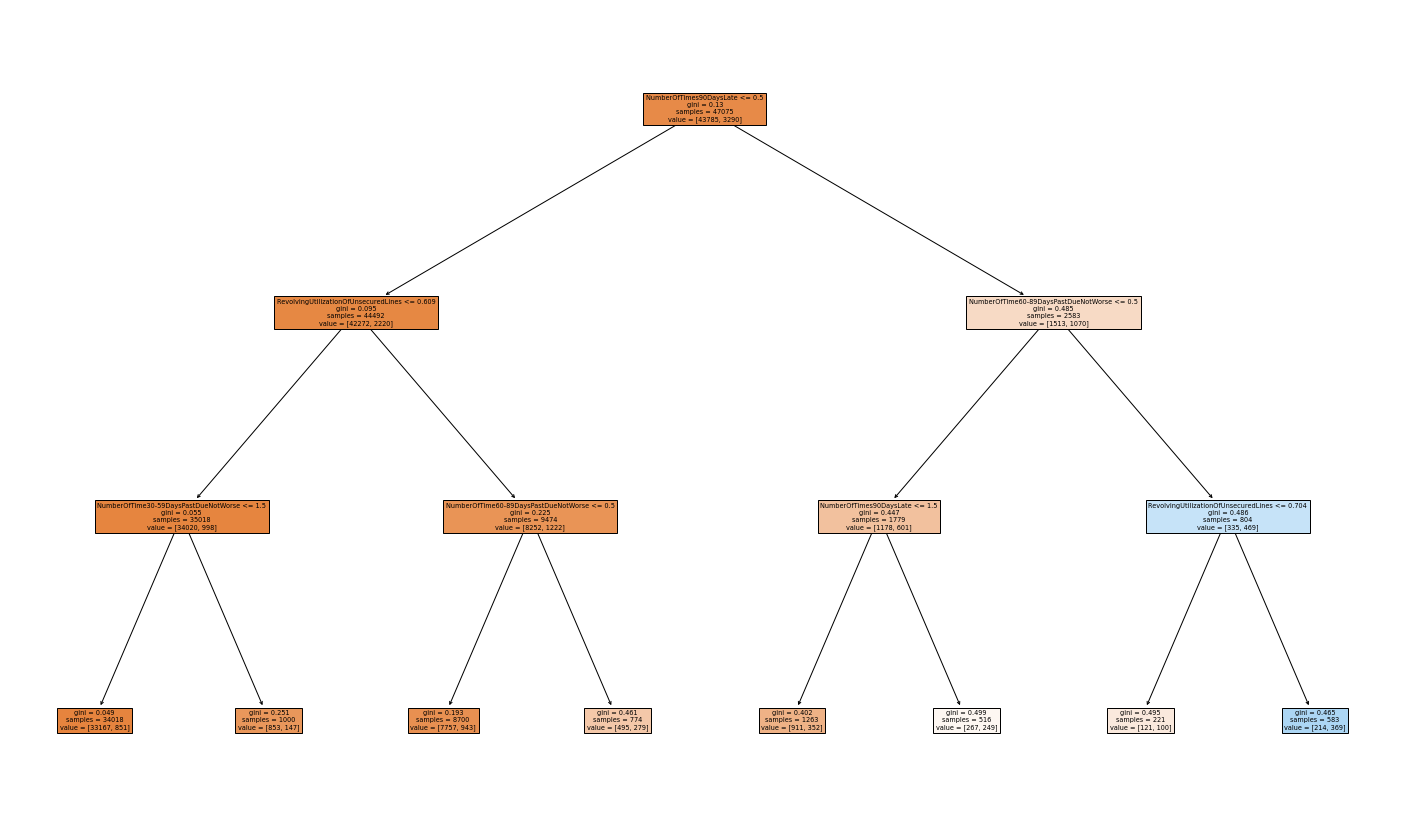

In [25]:
## Defining the input and target variables
train_clean = train.dropna()
X = train_clean.drop(columns = ['Id', 'SeriousDlqin2yrs'], axis = 1)
Y = train_clean['SeriousDlqin2yrs']

## Spliting the data 
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.2, stratify = Y)

## Building the decision tree on the train data-frame
tree_md = DecisionTreeClassifier(max_depth = 3).fit(X_train, Y_train)

## Visualizing the decision-tree model 
fig = plt.figure(figsize = (25, 15))
plot_tree(tree_md, feature_names = X_train.columns, filled = True);

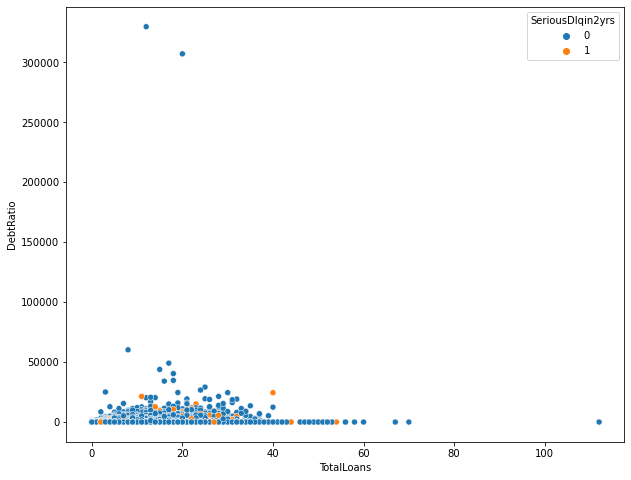

In [20]:
plt.figure(figsize = (10, 8))
sns.scatterplot(x = 'TotalLoans', y = 'DebtRatio', data = train, hue = 'SeriousDlqin2yrs')
plt.show()

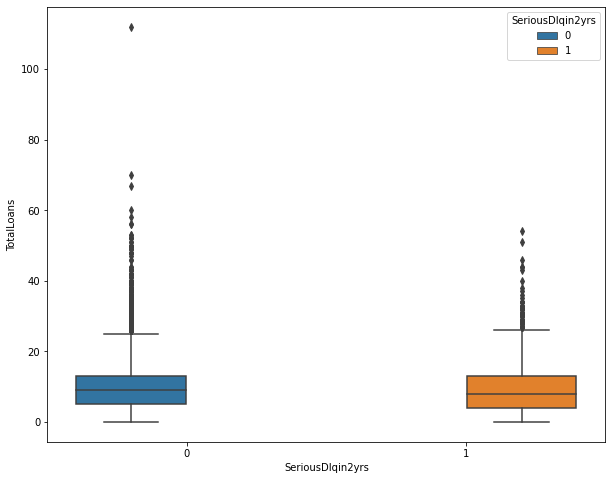

In [19]:
plt.figure(figsize = (10, 8))
sns.boxplot(x = 'SeriousDlqin2yrs', y = 'TotalLoans', data = train, hue = 'SeriousDlqin2yrs')
plt.show();

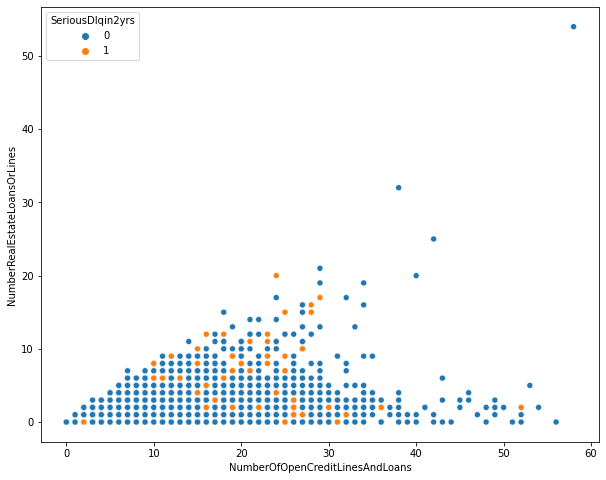

In [16]:
plt.figure(figsize = (10, 8))
sns.scatterplot(x = 'NumberOfOpenCreditLinesAndLoans', y = 'NumberRealEstateLoansOrLines', data = train, hue = 'SeriousDlqin2yrs')
plt.show();

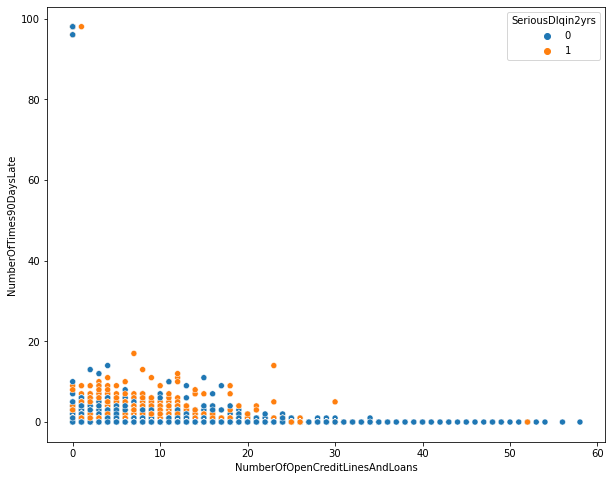

In [15]:
plt.figure(figsize = (10, 8))
sns.scatterplot(x = 'NumberOfOpenCreditLinesAndLoans', y = 'NumberOfTimes90DaysLate', data = train, hue = 'SeriousDlqin2yrs')
plt.show();

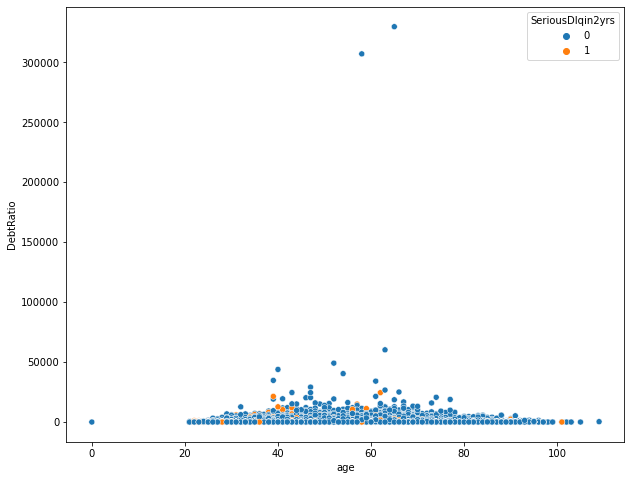

In [13]:
plt.figure(figsize = (10, 8))
sns.scatterplot(x = 'age', y = 'DebtRatio', data = train, hue = 'SeriousDlqin2yrs')
plt.show();

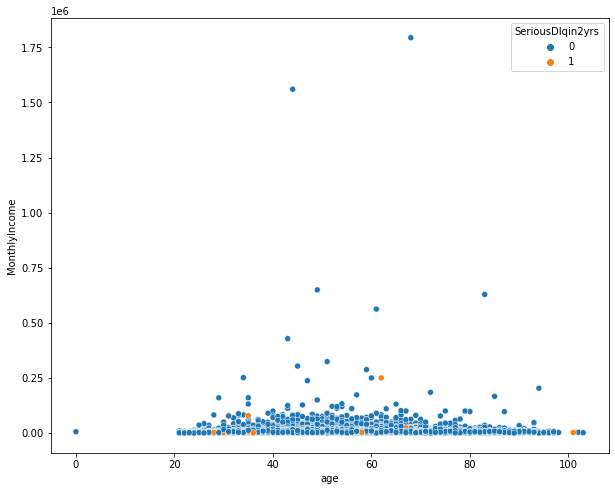

In [14]:
plt.figure(figsize = (10, 8))
sns.scatterplot(x = 'age', y = 'MonthlyIncome', data = train, hue = 'SeriousDlqin2yrs')
plt.show();

# Feature Engineering

In [ ]:
train['Late90days'] = np.where(train['NumberOfTimes90DaysLate'] >= 1, 1, 0)
train['Late60_90days'] = np.where(train['NumberOfTime60-89DaysPastDueNotWorse'] >= 1, 1, 0)



# Baseline Model: XGBoost

In [ ]:
X = train.drop(columns = ['Id', 'SeriousDlqin2yrs'], axis = 1)
Y = train['SeriousDlqin2yrs']

## Defining the hyper-parameter grid
XGBoost_param_grid = {'n_estimators': [100],
                      'max_depth': [5, 7],
                      'min_child_weight': [5, 7, 10],
                      'learning_rate': [0.01, 0.001],
                      'gamma': [0.3, 0.1],
                      'subsample': [0.8, 1],
                      'colsample_bytree': [0.8, 1]}

## Performing grid search with 5 folds
XGBoost_grid_search = GridSearchCV(XGBClassifier(), XGBoost_param_grid, cv = 5, scoring = 'roc_auc', n_jobs = -1, verbose = 3).fit(X, Y)

## Extracting the best score
best_score = XGBoost_grid_search.best_score_
print('The best area under the ROC cure is:', best_score)

## Extracting the best model
XGBoost_md = XGBoost_grid_search.best_estimator_

## Predicting on test with best xgboost model 
xgb_pred = XGBoost_md.predict_proba(test.drop(columns = ['Id'], axis = 1))[:, 1] 
xgb_pred

In [ ]:
from sklearn.metrics import roc_curve

def roc_auc_cutoff(Y_test, Y_pred):
    
    ## Computing the precision recall curve
    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
    
    cutoffs = pd.DataFrame({'False_Positive': fpr, 'True_Positive': tpr, 'cutoff': thresholds})

    ## Finding the optimal cut-off
    cutoffs['True_Positive_minus_1'] = cutoffs['True_Positive'] - 1
    cutoffs['Euclidean_dist'] = np.sqrt(cutoffs['False_Positive']**2 + cutoffs['True_Positive_minus_1']**2)

    ## Sorting based on the Euclidean distance
    cutoffs = cutoffs.sort_values(by = 'Euclidean_dist').reset_index(drop = True)
        
    return cutoffs['cutoff'][0]


xgb_pred_train = XGBoost_md.predict_proba(X)[:, 1]
opt_cutoff = roc_auc_cutoff(Y, xgb_pred_train)
print('The optimal cutoff is', opt_cutoff)

In [ ]:
xgb_pred_test = XGBoost_md.predict_proba(test.drop(columns = ['Id'], axis = 1))[:, 1]
xgb_label_test = np.where(xgb_pred_test < opt_cutoff, 0, 1)

In [ ]:
sum(xgb_label_test) / xgb_label_test.shape[0]

In [ ]:
xgb_label.shape

In [ ]:
test.shape

In [ ]:
data_out = pd.DataFrame({'Id': test['Id'], 'SeriousDlqin2yrs': xgb_label_test})
data_out.head()

In [ ]:
data_out['SeriousDlqin2yrs'].value_counts() / data_out.shape[0]

In [ ]:
data_out.to_csv('xgb_submission.csv', index = False)

# Baseline Model: LightGBM

In [ ]:
import boto3
import pandas as pd; pd.set_option('display.max_columns', 100)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_curve
from sklearn.impute import KNNImputer

s3 = boto3.resource('s3')
bucket_name = 'analytics-data-science-competitions'
bucket = s3.Bucket(bucket_name)

file_key_1 = 'Necesito-un-credito/train.csv'
file_key_2 = 'Necesito-un-credito/test.csv'

bucket_object_1 = bucket.Object(file_key_1)
file_object_1 = bucket_object_1.get()
file_content_stream_1 = file_object_1.get('Body')

bucket_object_2 = bucket.Object(file_key_2)
file_object_2 = bucket_object_2.get()
file_content_stream_2 = file_object_2.get('Body')

## Reading data-files
train = pd.read_csv(file_content_stream_1)
train['age'] = [train['age'][i][:-1] for i in range(0, train.shape[0])]
train['age'] = pd.to_numeric(train['age'])

test = pd.read_csv(file_content_stream_2)
test['age'] = [test['age'][i][:-1] for i in range(0, test.shape[0])]
test['age'] = pd.to_numeric(test['age'])

X = train.drop(columns = ['Id', 'SeriousDlqin2yrs'], axis = 1)
Y = train['SeriousDlqin2yrs']

## Defining the hyper-parameter grid
LightGBM_param_grid = {'n_estimators': [100, 300],
                       'max_depth': [3, 5, 7],
                       'num_leaves': [20, 25, 30],
                       'min_data_in_leaf': [10, 15, 20],
                       'learning_rate': [0.01, 0.001],
                       'feature_fraction': [0.8, 0.9, 1],
                       'lambda_l1': [0, 10, 100],
                       'lambda_l2': [0, 10, 100]
                      }

## Performing grid search with 5 folds
LightGBM_grid_search = GridSearchCV(LGBMClassifier(), LightGBM_param_grid, cv = 5, scoring = 'roc_auc', n_jobs = -1, verbose = 3).fit(X, Y)

## Extracting the best model
LightGBM_md = LightGBM_grid_search.best_estimator_

def roc_auc_cutoff(Y_test, Y_pred):
    
    ## Computing the precision recall curve
    fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
    
    cutoffs = pd.DataFrame({'False_Positive': fpr, 'True_Positive': tpr, 'cutoff': thresholds})

    ## Finding the optimal cut-off
    cutoffs['True_Positive_minus_1'] = cutoffs['True_Positive'] - 1
    cutoffs['Euclidean_dist'] = np.sqrt(cutoffs['False_Positive']**2 + cutoffs['True_Positive_minus_1']**2)

    ## Sorting based on the Euclidean distance
    cutoffs = cutoffs.sort_values(by = 'Euclidean_dist').reset_index(drop = True)
        
    return cutoffs['cutoff'][0]

## Predicting on train to estimate cutoff
lightgbm_pred_train = LightGBM_md.predict_proba(X)[:, 1]
opt_cutoff = roc_auc_cutoff(Y, lightgbm_pred_train)
print('The optimal cutoff is', opt_cutoff)

## Predicting on the test
lightgbm_pred_test = LightGBM_md.predict_proba(test.drop(columns = ['Id'], axis = 1))[:, 1]
lightgbm_label_test = np.where(lightgbm_pred_test < opt_cutoff, 0, 1)

## Data-frame for submission
data_out = pd.DataFrame({'Id': test['Id'], 'SeriousDlqin2yrs': lightgbm_label_test})
print(data_out.head())

data_out.to_csv('lightgbm_submission.csv', index = False)